In [1]:
# Fake News Detector with Bias Audit
# Lab Implementation using BERT and Fairlearn

In [2]:
!pip install torch transformers scikit-learn fairlearn pandas matplotlib seaborn numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import re
import string
from transformers import BertTokenizer, BertModel
import torch
import warnings
warnings.filterwarnings('ignore')

In [4]:
# For fairness evaluation
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import selection_rate, true_positive_rate, false_positive_rate

In [5]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [6]:
class FakeNewsDetector:
    def __init__(self, model_name='bert-base-uncased', max_length=128):
        """
        Initialize the Fake News Detector with BERT

        Args:
            model_name: BERT model to use
            max_length: Maximum sequence length for tokenization
        """
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.bert_model = BertModel.from_pretrained(model_name)
        self.classifier = None
        self.label_encoder = LabelEncoder()

    def create_sample_dataset(self, n_samples=1000):
        """
        Create a sample dataset for demonstration
        In real implementation, you would load actual dataset like LIAR
        """
        np.random.seed(42)

        # Sample headlines and articles
        fake_headlines = [
            "BREAKING: Scientists discover aliens living among us",
            "SHOCKING: Government hides cure for cancer",
            "URGENT: New study shows phones cause instant death",
            "EXCLUSIVE: Celebrity spotted with three-headed dog",
            "ALERT: Vaccines contain mind control chips",
            "REVEALED: Earth is actually flat, NASA admits",
            "BREAKING: Time travel invented by teenager",
            "SHOCKING: Politicians are actually robots",
            "URGENT: Coffee causes immediate hair loss",
            "EXCLUSIVE: Moon landing was filmed in garage"
        ]

        real_headlines = [
            "New COVID-19 variant detected in multiple countries",
            "Stock market shows mixed results amid economic uncertainty",
            "Climate change summit reaches important agreements",
            "Local election results announced after close race",
            "New study suggests benefits of Mediterranean diet",
            "Technology company announces quarterly earnings",
            "Government passes new infrastructure bill",
            "Research shows importance of regular exercise",
            "University receives grant for scientific research",
            "Community celebrates local business opening"
        ]

        # Generate dataset
        data = []
        for i in range(n_samples):
            if i % 2 == 0:  # Fake news
                text = np.random.choice(fake_headlines) + f" Additional content {i}"
                label = "fake"
            else:  # Real news
                text = np.random.choice(real_headlines) + f" Additional content {i}"
                label = "real"

            # Add demographic metadata
            gender = np.random.choice(['male', 'female', 'other'])
            party = np.random.choice(['democrat', 'republican', 'independent'])

            data.append({
                'text': text,
                'label': label,
                'gender': gender,
                'party': party
            })

        return pd.DataFrame(data)

    def preprocess_text(self, text):
        """
        Clean and preprocess text data

        Args:
            text: Raw text string

        Returns:
            Cleaned text string
        """
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_texts(self, texts):
        """
        Tokenize texts using BERT tokenizer

        Args:
            texts: List of text strings

        Returns:
            Dictionary with input_ids and attention_masks
        """
        input_ids = []
        attention_masks = []

        for text in texts:
            # Tokenize and encode
            encoded = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )

            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])

        return {
            'input_ids': torch.cat(input_ids, dim=0),
            'attention_masks': torch.cat(attention_masks, dim=0)
        }

    def get_bert_embeddings(self, texts):
        """
        Extract BERT embeddings for texts

        Args:
            texts: List of text strings

        Returns:
            numpy array of BERT embeddings
        """
        self.bert_model.eval()
        embeddings = []

        # Process in batches to avoid memory issues
        batch_size = 32
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            tokenized = self.tokenize_texts(batch_texts)

            with torch.no_grad():
                outputs = self.bert_model(
                    input_ids=tokenized['input_ids'],
                    attention_mask=tokenized['attention_masks']
                )

                # Use [CLS] token representation
                cls_embeddings = outputs.last_hidden_state[:, 0, :]
                embeddings.append(cls_embeddings.numpy())

        return np.vstack(embeddings)

    def train_model(self, X_train, y_train, classifier_type='logistic'):
        """
        Train the classification model

        Args:
            X_train: Training features (BERT embeddings)
            y_train: Training labels
            classifier_type: Type of classifier ('logistic' or 'random_forest')
        """
        if classifier_type == 'logistic':
            self.classifier = LogisticRegression(random_state=42, max_iter=1000)
        elif classifier_type == 'random_forest':
            self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            raise ValueError("classifier_type must be 'logistic' or 'random_forest'")

        self.classifier.fit(X_train, y_train)

    def evaluate_model(self, X_test, y_test):
        """
        Evaluate model performance

        Args:
            X_test: Test features
            y_test: Test labels

        Returns:
            Dictionary with performance metrics
        """
        y_pred = self.classifier.predict(X_test)

        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1_score': f1_score(y_test, y_pred, average='weighted')
        }

        return metrics, y_pred

    def fairness_audit(self, X_test, y_test, sensitive_features, y_pred):
        """
        Perform fairness audit using Fairlearn

        Args:
            X_test: Test features
            y_test: Test labels
            sensitive_features: DataFrame with sensitive attributes
            y_pred: Model predictions

        Returns:
            Dictionary with fairness metrics
        """
        fairness_results = {}

        for sensitive_attr in sensitive_features.columns:
            # Create MetricFrame for this sensitive attribute
            mf = MetricFrame(
                metrics={
                    'accuracy': accuracy_score,
                    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
                    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
                    'selection_rate': selection_rate
                },
                y_true=y_test,
                y_pred=y_pred,
                sensitive_features=sensitive_features[sensitive_attr]
            )

            # Calculate fairness metrics
            demo_parity_diff = demographic_parity_difference(
                y_test, y_pred, sensitive_features=sensitive_features[sensitive_attr]
            )

            eq_odds_diff = equalized_odds_difference(
                y_test, y_pred, sensitive_features=sensitive_features[sensitive_attr]
            )

            fairness_results[sensitive_attr] = {
                'metric_frame': mf,
                'demographic_parity_difference': demo_parity_diff,
                'equalized_odds_difference': eq_odds_diff
            }

        return fairness_results

    def plot_confusion_matrix(self, y_test, y_pred, title="Confusion Matrix"):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Fake', 'Real'],
                   yticklabels=['Fake', 'Real'])
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def plot_fairness_metrics(self, fairness_results):
        """
        Visualize fairness metrics
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        sensitive_attrs = list(fairness_results.keys())

        for i, attr in enumerate(sensitive_attrs):
            # Plot accuracy by group
            mf = fairness_results[attr]['metric_frame']
            accuracy_by_group = mf.by_group['accuracy']

            ax = axes[i, 0]
            accuracy_by_group.plot(kind='bar', ax=ax, color='skyblue')
            ax.set_title(f'Accuracy by {attr.capitalize()}')
            ax.set_ylabel('Accuracy')
            ax.tick_params(axis='x', rotation=45)

            # Plot fairness differences
            ax = axes[i, 1]
            fairness_diffs = [
                fairness_results[attr]['demographic_parity_difference'],
                fairness_results[attr]['equalized_odds_difference']
            ]
            fairness_names = ['Demographic Parity\nDifference', 'Equalized Odds\nDifference']

            bars = ax.bar(fairness_names, fairness_diffs, color=['coral', 'lightgreen'])
            ax.set_title(f'Fairness Metrics for {attr.capitalize()}')
            ax.set_ylabel('Difference')
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

            # Add value labels on bars
            for bar, value in zip(bars, fairness_diffs):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{value:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def run_complete_pipeline(self):
        """
        Run the complete pipeline from data loading to fairness audit
        """
        print("=" * 60)
        print("FAKE NEWS DETECTOR WITH BIAS AUDIT")
        print("=" * 60)

        # Step 1: Load and preprocess data
        print("\nStep 1: Data Preprocessing")
        print("-" * 30)

        df = self.create_sample_dataset(500)  # Smaller dataset for demo
        print(f"Dataset shape: {df.shape}")
        print(f"Label distribution:\n{df['label'].value_counts()}")
        print(f"Gender distribution:\n{df['gender'].value_counts()}")
        print(f"Party distribution:\n{df['party'].value_counts()}")

        # Preprocess text
        df['cleaned_text'] = df['text'].apply(self.preprocess_text)

        # Encode labels
        y = self.label_encoder.fit_transform(df['label'])

        # Step 2: Split data
        print("\nStep 2: Data Splitting")
        print("-" * 30)

        X_train_text, X_test_text, y_train, y_test, train_idx, test_idx = train_test_split(
            df['cleaned_text'].values, y, df.index, test_size=0.2, random_state=42, stratify=y
        )

        # Get sensitive features for test set
        sensitive_features_test = df.iloc[test_idx][['gender', 'party']].reset_index(drop=True)

        print(f"Training set size: {len(X_train_text)}")
        print(f"Test set size: {len(X_test_text)}")

        # Step 3: Generate BERT embeddings
        print("\nStep 3: BERT Tokenization and Embedding Generation")
        print("-" * 30)

        print("Generating BERT embeddings for training data...")
        X_train_embeddings = self.get_bert_embeddings(X_train_text)

        print("Generating BERT embeddings for test data...")
        X_test_embeddings = self.get_bert_embeddings(X_test_text)

        print(f"Embedding shape: {X_train_embeddings.shape}")

        # Step 4: Train model
        print("\nStep 4: Model Training")
        print("-" * 30)

        print("Training Logistic Regression classifier...")
        self.train_model(X_train_embeddings, y_train, classifier_type='logistic')
        print("Model training completed!")

        # Step 5: Evaluate model
        print("\nStep 5: Model Evaluation")
        print("-" * 30)

        metrics, y_pred = self.evaluate_model(X_test_embeddings, y_test)

        print("Performance Metrics:")
        for metric, value in metrics.items():
            print(f"  {metric.capitalize()}: {value:.4f}")

        # Step 6: Fairness audit
        print("\nStep 6: Fairness & Bias Audit")
        print("-" * 30)

        fairness_results = self.fairness_audit(
            X_test_embeddings, y_test, sensitive_features_test, y_pred
        )

        # Print fairness results
        for attr, results in fairness_results.items():
            print(f"\nFairness Results for {attr.capitalize()}:")
            print(f"  Demographic Parity Difference: {results['demographic_parity_difference']:.4f}")
            print(f"  Equalized Odds Difference: {results['equalized_odds_difference']:.4f}")

            print(f"  Accuracy by {attr}:")
            for group, acc in results['metric_frame'].by_group['accuracy'].items():
                print(f"    {group}: {acc:.4f}")

        # Step 7: Visualization
        print("\nStep 7: Visualization and Reporting")
        print("-" * 30)

        # Plot confusion matrix
        self.plot_confusion_matrix(y_test, y_pred, "Fake News Detection - Confusion Matrix")

        # Plot fairness metrics
        self.plot_fairness_metrics(fairness_results)

        # Classification report
        print("\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred,
                                  target_names=self.label_encoder.classes_))

        print("\n" + "=" * 60)
        print("ANALYSIS COMPLETE")
        print("=" * 60)

        return {
            'model': self.classifier,
            'metrics': metrics,
            'fairness_results': fairness_results,
            'predictions': y_pred,
            'test_labels': y_test
        }

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

FAKE NEWS DETECTOR WITH BIAS AUDIT

Step 1: Data Preprocessing
------------------------------
Dataset shape: (500, 4)
Label distribution:
label
fake    250
real    250
Name: count, dtype: int64
Gender distribution:
gender
male      190
female    157
other     153
Name: count, dtype: int64
Party distribution:
party
independent    169
democrat       166
republican     165
Name: count, dtype: int64

Step 2: Data Splitting
------------------------------
Training set size: 400
Test set size: 100

Step 3: BERT Tokenization and Embedding Generation
------------------------------
Generating BERT embeddings for training data...
Generating BERT embeddings for test data...
Embedding shape: (400, 768)

Step 4: Model Training
------------------------------
Training Logistic Regression classifier...
Model training completed!

Step 5: Model Evaluation
------------------------------
Performance Metrics:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1_score: 1.0000

Step 6: Fairness & Bias

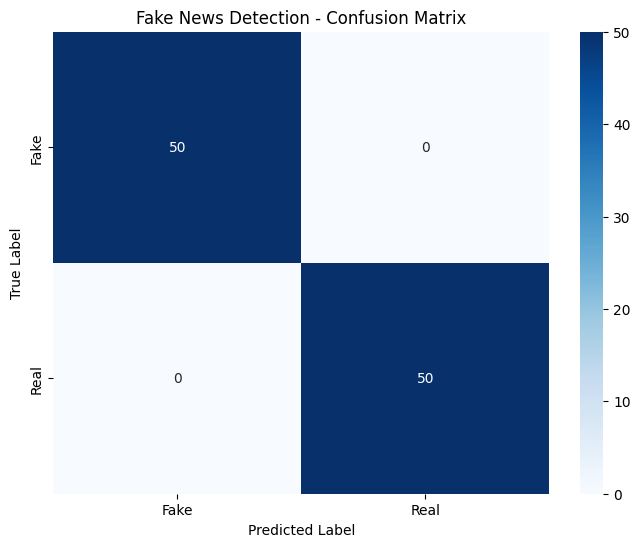

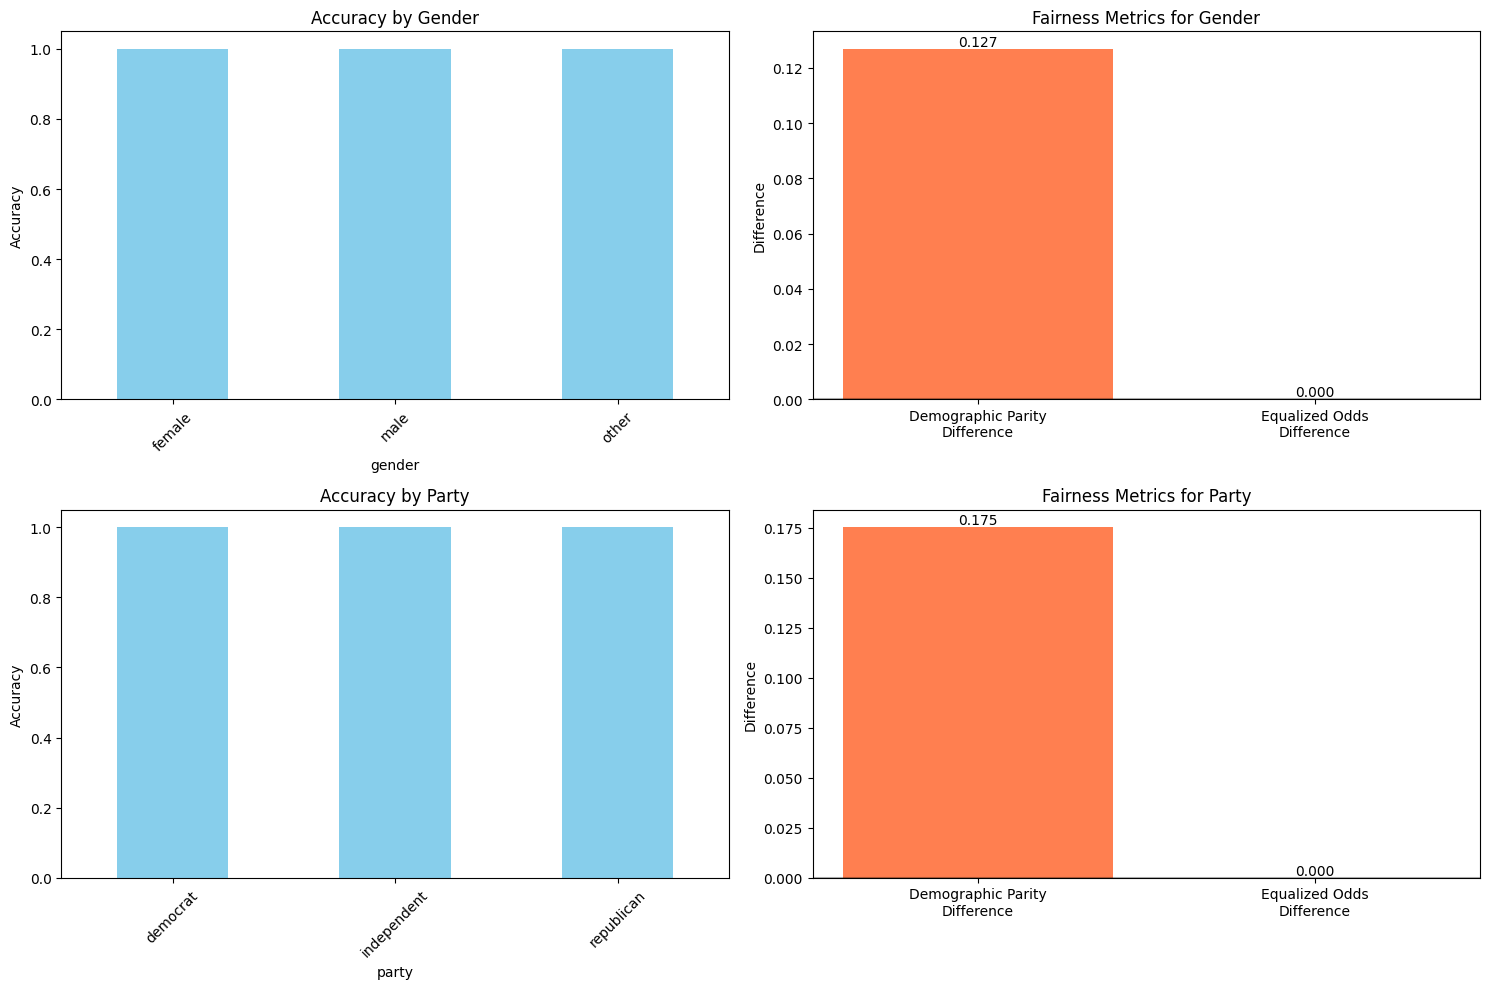


Detailed Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        50
        real       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


ANALYSIS COMPLETE

Bias Analysis Summary:
----------------------------------------

Gender Bias Assessment:
  Demographic Parity: 0.1269 (MODERATE BIAS)
  Equalized Odds: 0.0000 (ACCEPTABLE)

Party Bias Assessment:
  Demographic Parity: 0.1752 (MODERATE BIAS)
  Equalized Odds: 0.0000 (ACCEPTABLE)

Recommendations:
- Values close to 0 indicate fairness
- Values > 0.1 may indicate bias that needs attention
- Consider data balancing or fairness constraints if bias is detected


In [7]:
# Example usage
if __name__ == "__main__":
    # Initialize the detector
    detector = FakeNewsDetector()

    # Run the complete pipeline
    results = detector.run_complete_pipeline()

    # Additional analysis
    print("\nBias Analysis Summary:")
    print("-" * 40)

    for attr, results in results['fairness_results'].items():
        demo_parity = results['demographic_parity_difference']
        eq_odds = results['equalized_odds_difference']

        print(f"\n{attr.capitalize()} Bias Assessment:")

        # Demographic parity assessment
        if abs(demo_parity) < 0.1:
            demo_status = "ACCEPTABLE"
        elif abs(demo_parity) < 0.2:
            demo_status = "MODERATE BIAS"
        else:
            demo_status = "HIGH BIAS"

        # Equalized odds assessment
        if abs(eq_odds) < 0.1:
            eq_status = "ACCEPTABLE"
        elif abs(eq_odds) < 0.2:
            eq_status = "MODERATE BIAS"
        else:
            eq_status = "HIGH BIAS"

        print(f"  Demographic Parity: {demo_parity:.4f} ({demo_status})")
        print(f"  Equalized Odds: {eq_odds:.4f} ({eq_status})")

    print("\nRecommendations:")
    print("- Values close to 0 indicate fairness")
    print("- Values > 0.1 may indicate bias that needs attention")
    print("- Consider data balancing or fairness constraints if bias is detected")